In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
land_data = pd.read_csv('Train.csv')

In [3]:
# Check missing values, duplicates
land_data.isnull().sum().any(), land_data.duplicated().any()

(False, False)

In [4]:
land_data.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,...,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281729,1.281693,0
1,2,161,158,155,153,151,162,159,155,153,...,1.359639,1.359608,1.359587,1.359556,1.359683,1.359662,1.359631,1.359610,1.359579,1
2,3,149,151,154,156,158,154,157,158,160,...,1.365005,1.365025,1.365055,1.365075,1.364937,1.364967,1.364988,1.365018,1.365038,0
3,4,80,78,77,75,73,80,78,77,75,...,1.100708,1.100738,1.100759,1.100789,1.100630,1.100650,1.100680,1.100700,1.100731,0
4,5,117,115,114,112,110,115,113,111,110,...,1.284180,1.284130,1.284056,1.284006,1.284125,1.284050,1.284001,1.283926,1.283876,0


In [5]:
land_data.shape

(10864, 227)

In [6]:
features = ['elevation', 'slope', 'aspect', 'placurv', 'procurv', 'lsfactor', 'twi', 'sdoif']  # features of every location
slide_location=['13']  # landslides happens at location 13
neighbors = ['7','8','9','12','14','17','18','19']

for ft in features:
    for i in neighbors:
        land_data[f'{ft}_{i}_diff'] = land_data[f'13_{ft}'] - land_data[f'{i}_{ft}']      

# feature engineering 
# mean and std of neighbor cells
for ft in features:
  cols = [x for x in land_data.columns if x.endswith(ft) and any(j in x for j in neighbors)]
  land_data[f'neighbors_{i}_mean'] = land_data[cols].mean(axis=1)
  land_data[f'neighbors_{i}_std'] = land_data[cols].std(axis=1)

# cross features - mean and std of each row
for ft in features:
    cols = [x for x in land_data.columns if x.endswith(ft)]
    land_data[f'{ft}_mean'] = land_data[cols].mean(axis=1)
    land_data[f'{ft}_std'] = land_data[cols].std(axis=1)

In [7]:
land_data['Label2'] = land_data['Label']
land_data.drop(['Label'], axis=1, inplace = True)

In [8]:
land_data.shape

(10864, 309)

In [9]:
# xgb works with categorical vars
for i in ['geology']:
     cols = [x for x in land_data.columns if x.endswith(i)]
for col in cols:
    land_data[col]=land_data[col].astype('category')
# land_data['1_geology']

In [10]:
# splitting data
from sklearn.model_selection import train_test_split
X = land_data.iloc[:, 1:307].values
y = land_data.iloc[:, 308].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, stratify = y, random_state = 2024)

In [11]:
X[y==1].shape, X[y==0].shape # class imbalance

((2716, 306), (8148, 306))

In [12]:
# upsample to battle class imba
from sklearn.utils import resample
X_upsampled, y_upsampled = resample(
    X_train[y_train==1],
    y_train[y_train==1], 
    replace = True, 
    n_samples = X_train[y_train==0].shape[0], random_state = 2024)

In [13]:
# from sklearn.model_selection import StratifiedKfold
# kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
# scores = cross_val_score(estimator = XGB, X = X_train, y = y_train, cv = 10, n_jobs = -1)

In [14]:
X_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_bal = np.hstack((y_train[y_train == 0], y_upsampled))

In [15]:
X_upsampled.shape[0]

7333

In [16]:
X_bal[y_bal==1].shape[0], X_bal[y_bal==0].shape[0]

(7333, 7333)

In [17]:
model = xgb.XGBClassifier(n_estimators=1000, 
                          learning_rate=0.01, 
                          max_depth=8,
                          enable_categorical=True, colsample_bytree=0.5, subsample=0.5, gamma=7, min_child_weight=10,
                          random_state=2024, 
                          use_label_encoder=False)

scores = cross_val_score(estimator=model, X=X_bal, y=y_bal, cv=10, n_jobs=-1)

In [18]:
print(np.mean(scores))

0.8961526479316216


In [19]:
print(scores)

[0.89434219 0.89502386 0.89911384 0.9072938  0.9127471  0.89366053
 0.89631651 0.88472033 0.88949523 0.8888131 ]


In [20]:
from sklearn.metrics import accuracy_score
gbm = model.fit(X_bal, y_bal)
y_train_pred = gbm.predict(X_bal)
y_test_pred = gbm.predict(X_test)
gbm_train = accuracy_score(y_bal, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGBoost train/test accuracies {gbm_train:.3f}/{gbm_test:.3f}')

XGBoost train/test accuracies 0.941/0.862


In [21]:
# gbm.feature_importances_

[[722  93]
 [ 57 215]]


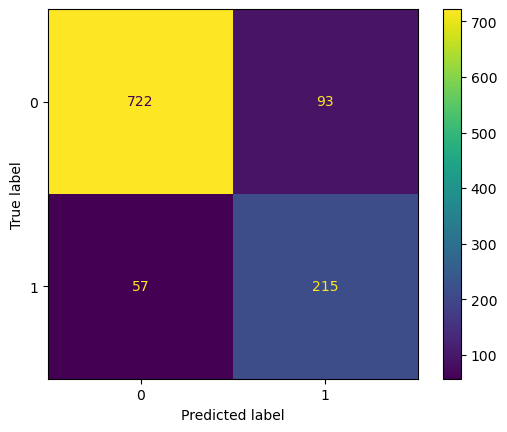

In [22]:
conf_mat = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
print(conf_mat)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

In [23]:
auc_score = roc_auc_score(y_true=y_test, y_score = y_test_pred)
auc_score

0.8381653735113677

In [24]:
MCC = matthews_corrcoef(y_true = y_test, y_pred = y_test_pred)
MCC

0.650097208001111

In [25]:
F1 = f1_score(y_true = y_test, y_pred = y_test_pred)
F1

0.7413793103448276